### Notebook con la tratamiento y selección de las variables que usará el modelo. 

#### Importando librerías 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import pickle

from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
#from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import transformer
from transformer import MCC_encoder, MerchantStateEncoder, UseChipEncoder




pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#### Lectura de la base de datos.

El Análisis Exploratorio de los Datos (EDA) indica que las variables relevantes para la creación del modelo de fraude son: **'Card', 'Amount', 'Use Chip', 'Merchant State' y 'MCC'**. Se incluyen además **'Year', 'Month' y 'Is Fraud?'** al ser variables necesarias para el modelo de fraude y para el posterior estudio de forecasting. 

In [2]:
df = pd.read_csv('/Users/mac/Desktop/DataScience/LANA/credit_card_transactions-ibm_v2.csv', 
                usecols=['Card', 'Year', 'Month', 'Amount', 'Use Chip', 'Merchant State', 
                         'MCC', 'Is Fraud?'])

#### Selección de los datos de los últimos cinco años.

Se considera que un estudio que englobe los últimos 5 años, puede aportar la estabilidad necesaria en el estudio.

In [3]:
df = df.query("Year >= 2015")

#### Transformación de las variables categóricas Amount, Use Chip, Merchant State y Is Fraud? a numéricas.

#### * Is Fraud?

In [4]:
df['target'] = np.where(df['Is Fraud?'] == 'No', 0, 1)
df['target'].value_counts(normalize=1)

0    0.998688
1    0.001312
Name: target, dtype: float64

#### * Amount

In [5]:
def trim_dollar_sign(x):
    return str(x)[1:]

df['Amount'] = df['Amount'].apply(trim_dollar_sign)
df['Amount'] = df['Amount'].astype(float)

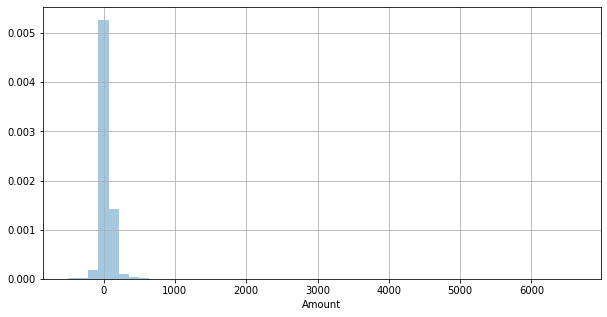

In [6]:
plt.figure(figsize = (10,5))
sns.distplot(df['Amount'], kde=False, norm_hist = True)
plt.grid()

Dado que "Amount" toma valores negativos para unas 436744 transacciones y, a falta de una mayor información, estos valores no tienen sentido, y son eliminados de la base de datos. Como se ha comentado en el Jupyter-Notebook de EDA, será en la Pipeline de transformación de datos donde se procederá a la agrupación de esta variable. 

In [7]:
df = df[df['Amount']>0]

#### * Merchant State 

+ Como está explicado en el Jupyter-Notebook del EDA, vamos a seleccionar los estados de EEUU para hacer este estudio, al no presentar suficientes datos para poder extener el estudio a otros paises. Esta muestra representa el 88% de las transacciones presentes en la base de datos. 
+ Cabe indicar que, en cualquier caso, se desanconseja la inversión en los siguientes paises: **Fiji, Tuvalu, Algeria, Haiti, Nigeria, Turkey, Italy, Japan, Mexico y la India**

In [8]:
# Selección de los estados de EEUU:

def lenth_states(x):
    return len(x)

df['length_MerchantState'] = df['Merchant State'].astype(str).apply(lenth_states)

df['USMerchantState'] = 0
df.loc[df.query("length_MerchantState == 2").index, 'USMerchantState'] = 1
print(df['USMerchantState'].value_counts())


df = df[df['USMerchantState']== 1]

1    7313559
0    1165405
Name: USMerchantState, dtype: int64


#### * MCC ( Merchant category code)

Distribución de la tasa de fraude para MCC

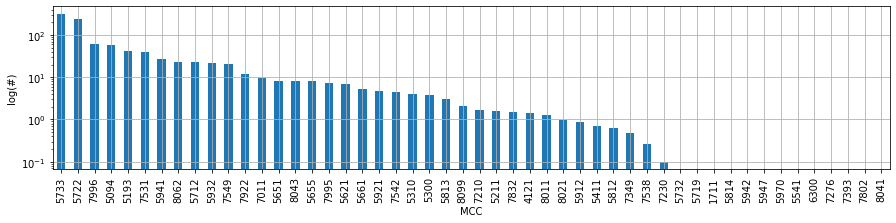

In [9]:
feature = 'MCC'

df_temp = pd.DataFrame()
df_temp['mean_target'] = df.groupby(feature)['target'].mean()
df_temp['norm_mean_target'] = df.groupby(feature)['target'].mean()/df['target'].mean()
df_temp['n_counts'] = df.groupby(feature)['target'].count()
df_temp.sort_values(by='norm_mean_target', ascending=False, inplace=True)

plt.figure(figsize=(16,6))
df_temp.norm_mean_target.head(50).plot.bar(figsize=(15,3))
plt.grid()
plt.xlabel('MCC')
plt.ylabel('log(#)')
plt.yscale('log')


Dada la alta cardinalidad de esta variable, se procede a agruparla. Para determinar el número de grupos, se aplica la técnica del 'Elbow':

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

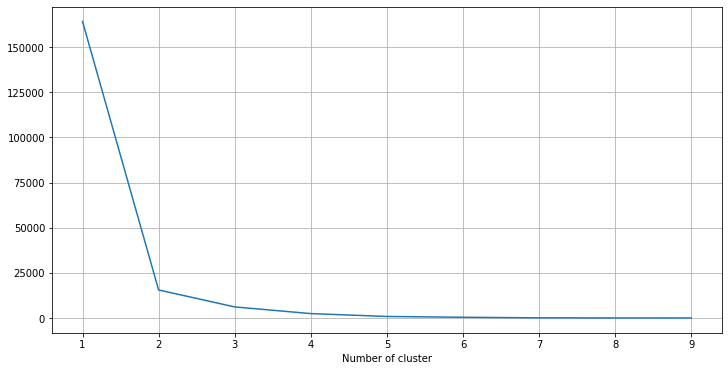

In [10]:
sse={} # sum of the squared errors.
feat = df_temp[['norm_mean_target']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(feat)
    feat["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 

plt.figure(figsize=(12,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.grid()

#### RESULTADO:

+ A partir de un número de grupos igual a 3, los errores se estabilizan. Por tanto, se agrupará esta variable en 3 grupos:

In [11]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_temp[['norm_mean_target']])
df_temp['Cluster'] = kmeans.predict(df_temp[['norm_mean_target']])

print(df_temp.groupby('Cluster')['mean_target'].mean().sort_values(ascending=True))

Cluster
0    0.000155
2    0.004930
1    0.039394
Name: mean_target, dtype: float64


#### Definición del diccionario

In [12]:
dict_mcc = {0: 0, 1: 2, 2: 1}
df_temp['Cluster'] = df_temp['Cluster'].map(dict_mcc)
df_temp.head()

,mean_target,norm_mean_target,n_counts,Cluster
5733,0.045455,322.438894,132,2
5722,0.033333,236.455189,210,2
7996,0.008503,60.320201,3528,1
5094,0.008022,56.906834,3241,1
5193,0.006047,42.894365,2646,1


In [13]:
df_temp.reset_index(drop=False, inplace=True)
dict_mcc = {i: k for i,k in zip(df_temp['index'], df_temp['Cluster'])}
df['MCC_Cluster'] = df['MCC'].map(dict_mcc)

#### Este diccionario será implementado posteriormente en la Pipeline de transformación en este Jupyter-Notebook. 

In [15]:
df['MCC_Cluster'].unique()

array([0, 1, 2])

In [17]:
df.head(3)

,Card,Year,Month,Amount,Use Chip,Merchant State,MCC,Is Fraud?,target,length_MerchantState,USMerchantState,MCC_Cluster
3895,0,2015,1,34.99,Chip Transaction,CA,5411,No,0,2,1,0
3896,0,2015,1,1.67,Chip Transaction,CA,5499,No,0,2,1,0
3897,0,2015,1,208.96,Chip Transaction,CA,4814,No,0,2,1,0


#### * Use Chip', 'Merchant State'

Para poder continuar transformando estas variables de tipo categórico a numérico, necesitamos dividir la muestra. Por eso, esta transformación se hará más adelante.

#### * Date

Vamos a crear esta variable en la base de datos para poder hacer estudios temporales.

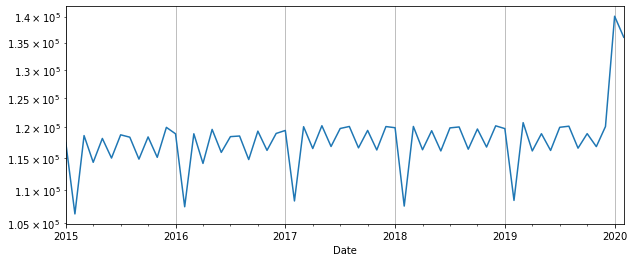

In [18]:
df['Date'] = df['Year'].astype('str') + '-' + df['Month'].astype('str') + '-01'

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

plt.figure(figsize=(10,4))
df.groupby('Date')['target'].count().plot()
plt.grid()
plt.yscale('log')

#### Analizamos si hay Missing Data en la base de datos resultante.

In [19]:
df.isnull().mean()

Card                    0.0
Year                    0.0
Month                   0.0
Amount                  0.0
Use Chip                0.0
Merchant State          0.0
MCC                     0.0
Is Fraud?               0.0
target                  0.0
length_MerchantState    0.0
USMerchantState         0.0
MCC_Cluster             0.0
Date                    0.0
dtype: float64

#### **Resultado**:
No hay datos faltantes, condición necesaria para poder aplicar cualquier modelo.

#### Eliminamos las columnas que no vamos a usar:

In [20]:
df.columns

Index(['Card', 'Year', 'Month', 'Amount', 'Use Chip', 'Merchant State', 'MCC',
       'Is Fraud?', 'target', 'length_MerchantState', 'USMerchantState',
       'MCC_Cluster', 'Date'],
      dtype='object')

In [21]:
df.drop(['Is Fraud?', 'length_MerchantState', 'USMerchantState', 'MCC_Cluster'], axis = 1, inplace = True)
df.head(3)

,Card,Year,Month,Amount,Use Chip,Merchant State,MCC,target,Date
3895,0,2015,1,34.99,Chip Transaction,CA,5411,0,2015-01-01
3896,0,2015,1,1.67,Chip Transaction,CA,5499,0,2015-01-01
3897,0,2015,1,208.96,Chip Transaction,CA,4814,0,2015-01-01


#####   *Chip, Merchant State

Para hacer una buena transformación de las variables, es conveniente separar la muestra en dos grupos: train y test. El primer grupo sirve para definir las transformaciones y el segundo para validar que dichas transformaciones sean válidas para cualquier set de datos.

In [22]:
frac_test = 0.15
#random_number = np.random.randint(1,100)
#print(random_number)

X_train, X_test, y_train, y_test = train_test_split(df, df, test_size=frac_test, random_state=34)

In [23]:
X_train.head()

,Card,Year,Month,Amount,Use Chip,Merchant State,MCC,target,Date
11110068,2,2019,1,227.00,Swipe Transaction,IL,3780,0,2019-01-01
1023430,3,2019,8,1.20,Chip Transaction,AL,5499,0,2019-08-01
5970974,2,2016,8,88.76,Chip Transaction,CT,5411,0,2016-08-01
17001120,3,2018,4,1.34,Chip Transaction,OR,5499,0,2018-04-01
21348204,0,2019,11,5.47,Swipe Transaction,CA,5942,0,2019-11-01


###  Pipeline para la transformación de las variables categóricas "Use Chip" y "Merchant State":

In [24]:
list_features = ['MCC', 'Merchant State', 'Use Chip', 'Amount']


# Individual Pipeline Definitions
pipeline_mcc = Pipeline([('MCC_encoder', MCC_encoder())])
pipeline_merchantstate = Pipeline([('MerchantStateEncoder', MerchantStateEncoder())])
pipeline_usechip = Pipeline([('UseChipEncoder', UseChipEncoder())])
pipeline_amount = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('binning', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
    ])



# Main Transformer
preprocessor = ColumnTransformer(transformers=[
    ('pipeline_mcc', pipeline_mcc, ['MCC']),
    ('pipeline_merchantstate', pipeline_merchantstate, ['Merchant State']),
    ('pipeline_usechip', pipeline_usechip, ['Use Chip']),
    ('pipeline_amount', pipeline_amount, ['Amount']),
    ], remainder='passthrough', verbose=False)    



#### Entrenamiento de la Pipeline. Creación de un Pickel para su posterior uso.

In [25]:
preprocessor.fit(X_train[list_features])
X_train_pipe = pd.DataFrame(preprocessor.transform(X_train[list_features]))
X_train_pipe.columns = list_features
print(X_train_pipe.head(2))


# Now we perpetuate the pipeline into a Pickel.
with open("feature_pipeline.pkl", "wb") as file:
    pickle.dump(preprocessor, file, -1)    


   MCC  Merchant State  Use Chip  Amount
0  1.0            10.0       2.0     9.0
1  1.0            16.0       1.0     0.0


#### Sanity Check:

In [26]:
print('reading pickel....')
with open("feature_pipeline.pkl", "rb") as file:
     preprocessor_test = pickle.load(file)

X_train_pipe2 = pd.DataFrame(preprocessor_test.transform(X_train[list_features]))
X_train_pipe2.columns = list_features
print(X_train_pipe2.head(2))

reading pickel....
   MCC  Merchant State  Use Chip  Amount
0  1.0            10.0       2.0     9.0
1  1.0            16.0       1.0     0.0


#### Transformamos toda la base de datos:

In [27]:
df_pipe = pd.DataFrame(preprocessor.transform(df[list_features]))
df_pipe.columns = list_features
df_pipe.head(3)

,MCC,Merchant State,Use Chip,Amount
0,4.0,1.0,1.0,5.0
1,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,9.0


In [28]:
df[list_features].head()

,MCC,Merchant State,Use Chip,Amount
3895,5411,CA,Chip Transaction,34.99
3896,5499,CA,Chip Transaction,1.67
3897,4814,CA,Chip Transaction,208.96
3898,5300,CA,Chip Transaction,136.58
3899,5651,CA,Chip Transaction,128.64


In [30]:
df_final = pd.concat([df.reset_index(drop=True), 
                      df_pipe.reset_index(drop=True)], 
                     axis = 1, ignore_index = True)


df_final.columns = ['Card', 'Year', 'Month', 'Amount', 'Use Chip', 'Merchant State', 'MCC',
       'target', 'Date', 'MCC FE', 'Merchant State FE', 'Use Chip FE', 'Amount FE']

df_final.head(3)



,Card,Year,Month,Amount,Use Chip,Merchant State,MCC,target,Date,MCC FE,Merchant State FE,Use Chip FE,Amount FE
0,0,2015,1,34.99,Chip Transaction,CA,5411,0,2015-01-01,4.0,1.0,1.0,5.0
1,0,2015,1,1.67,Chip Transaction,CA,5499,0,2015-01-01,1.0,1.0,1.0,0.0
2,0,2015,1,208.96,Chip Transaction,CA,4814,0,2015-01-01,1.0,1.0,1.0,9.0


In [31]:
df_final.columns.tolist()

['Card',
 'Year',
 'Month',
 'Amount',
 'Use Chip',
 'Merchant State',
 'MCC',
 'target',
 'Date',
 'MCC FE',
 'Merchant State FE',
 'Use Chip FE',
 'Amount FE']

#### Salvamos la base de datos final, que será usada por los modelos que se aplican en el Jupyter Notebook - Model.

In [32]:
df_final[['Card', 'Amount FE', 'MCC FE', 'Merchant State FE', 'Use Chip FE', 'Date', 'target']].to_csv('/Users/mac/Desktop/DataScience/LANA/credit_card_transactions-ibm_v2_pipelined.csv', index = False)

#### Test Kolmogorov-Smirnov.

Este test estadístico no paramétrico se utiliza para cuantificar la capacidad discriminatoria de una variable respecto de dos poblaciones. En nuestro caso, población de alto y bajo riesgo de fraude. 

In [34]:
df_ini_ks = pd.read_csv('/Users/mac/Desktop/DataScience/LANA/credit_card_transactions-ibm_v2_pipelined.csv')
df_ini_ks.head(3)

,Card,Amount FE,MCC FE,Merchant State FE,Use Chip FE,Date,target
0,0,5.0,4.0,1.0,1.0,2015-01-01,0
1,0,0.0,1.0,1.0,1.0,2015-01-01,0
2,0,9.0,1.0,1.0,1.0,2015-01-01,0


In [37]:
all_features = ['Card', 'Amount FE', 'MCC FE', 'Merchant State FE', 'Use Chip FE']

#  'Zip_Clusters'
n_features = len(all_features)
ks = np.zeros(n_features)

for i in range (0,  n_features):

    feature = all_features[i]
    dist1 = df_ini_ks['{}'.format(feature)].loc[df_ini_ks['{}'.format('target')] == 1]
    dist2 = df_ini_ks['{}'.format(feature)].loc[df_ini_ks['{}'.format('target')] == 0]  
    ks[i] = stats.ks_2samp(dist1, dist2)[0]
    df_ks = pd.DataFrame(data={"KS": ks}, index=all_features)
    
df_ks = df_ks.sort_values(by=['KS'],ascending=False)
df_ks["n"] = np.arange(n_features)+1

df_ks.head(100)

,KS,n
Amount FE,0.293587,1
Use Chip FE,0.230927,2
MCC FE,0.197897,3
Merchant State FE,0.107748,4
Card,0.087561,5


#### Resultado:
+ Se observa que las variables con mayor poder discriminatorio entre poblaciones (alto KS) serían "Amount FE" y "Use Chip FE"
+ Como se verá durante el entrenamiento del modelo de fraude, estas dos variables también resultan ser las más importantes para el modelo. 